<a href="https://colab.research.google.com/github/FrancisKurian/GIS_SAM/blob/main/SAM2_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install segment-geospatial leafmap
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth


In [ ]:
import leafmap
import rasterio
from PIL import Image
import numpy as np
from samgeo import SamGeo
import clip
import torch

In [ ]:
# m = leafmap.Map(center=[33.64612535960701, -117.77343543807746], zoom=18, height="800px")
m = leafmap.Map(center=[33.64868689846684, -117.7760534796257], zoom=18, height="800px")



m.add_basemap("SATELLITE")

# Disable panning and zooming
m.dragging = False
m.scroll_wheel_zoom = False
m.touch_zoom = False
m.double_click_zoom = False
m.box_zoom = False

# Display the map
m

Map(box_zoom=False, center=[33.64868689846684, -117.7760534796257], controls=(ZoomControl(options=['position',…

In [ ]:
# Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map
if m.user_roi_bounds() is not None:
    bbox = m.user_roi_bounds()
else:
    # Default bounding box around Wilson Field and surrounding blocks
    bbox = [-117.854, 33.792, -117.850, 33.795]

print("Bounding Box:", bbox)

Bounding Box: [-117.7775, 33.6478, -117.7748, 33.6495]


In [ ]:
# Download maps tiles and mosaic them into a single GeoTIFF file
image = "satellite.tif"
leafmap.map_tiles_to_geotiff(
    output=image, bbox=bbox, zoom=18, source="Satellite", overwrite=True
)

Downloaded image 1/6
Downloaded image 2/6
Downloaded image 3/6
Downloaded image 4/6
Downloaded image 5/6
Downloaded image 6/6
Saving GeoTIFF. Please wait...
Image saved to satellite.tif


**Initialize SAM class**

In [ ]:
# Load GeoTIFF and convert to RGB format
with rasterio.open("satellite.tif") as src:
    img_array = src.read([1, 2, 3])  # RGB bands
    image = np.transpose(img_array, (1, 2, 0))  # Channels last
    image = Image.fromarray(image.astype(np.uint8))


In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load SAM
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth")
sam.to("cuda" if torch.cuda.is_available() else "cpu")
mask_generator = SamAutomaticMaskGenerator(sam)

image_np = np.array(image)

# Generate masks using the NumPy array
masks = mask_generator.generate(image_np)
print(f"Generated {len(masks)} masks.")


Generated 204 masks.


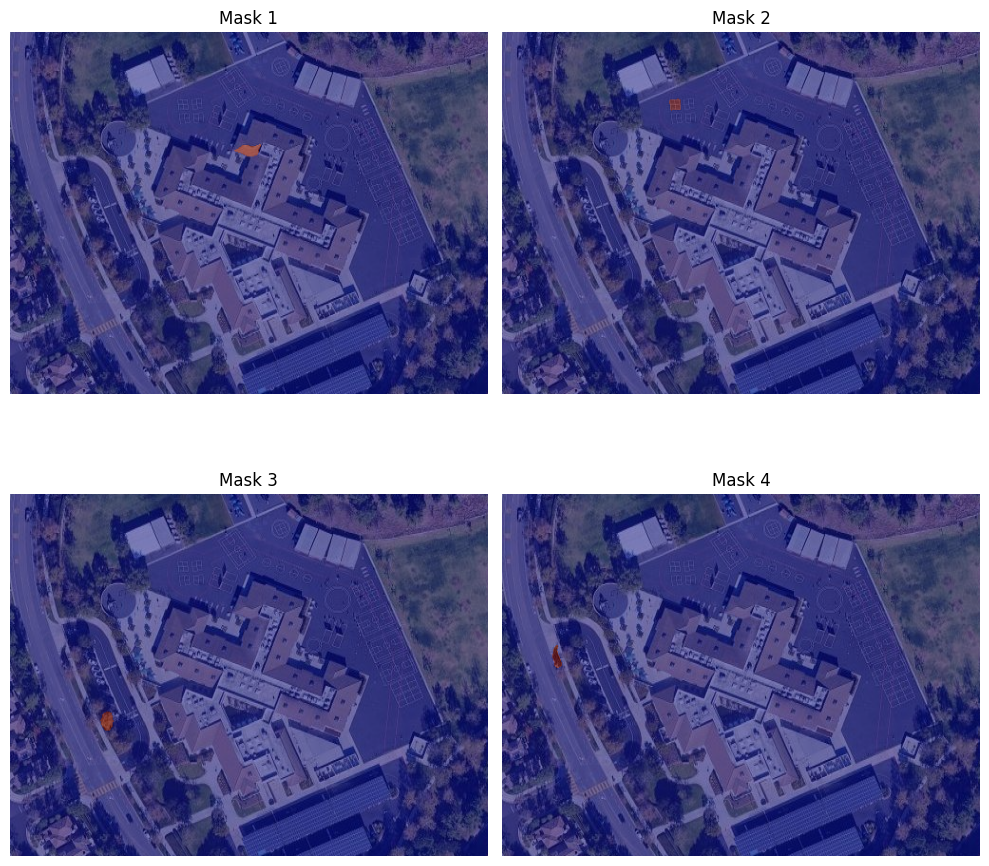

In [ ]:
import matplotlib.pyplot as plt
import random

# Choose 4 masks for a 2x2 layout
sample_size = 4
sample_masks = random.sample(masks, sample_size)

# Create a 2x2 grid for displaying masks
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()  # Flatten to iterate easily

for i, mask in enumerate(sample_masks):
    ax = axs[i]
    ax.imshow(image_np)
    ax.imshow(mask["segmentation"], alpha=0.5, cmap='jet')  # Semi-transparent mask
    ax.set_title(f"Mask {i+1}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import clip
import cv2

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Define label set based on your image
labels = [
    "Asphalt", "solar panel", "building",  "tree","green" "track field",
    "parking lot", "sidewalk",  "tennis court"
]
label_tokens = clip.tokenize(labels).to(device)
area_per_label = {label: 0 for label in labels}

# Loop through SAM masks and classify with CLIP
for i, mask in enumerate(masks):
    m = mask["segmentation"]
    if np.sum(m) < 500:
        continue

    ys, xs = np.where(m)
    if ys.size == 0 or xs.size == 0:
        continue

    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()
    padded = np.where(m[..., None], image, 255)[y_min:y_max+1, x_min:x_max+1]
    pil_img = Image.fromarray(padded).resize((224, 224))
    clip_input = preprocess(pil_img).unsqueeze(0).to(device)

    with torch.no_grad():
        image_features = model.encode_image(clip_input)
        text_features = model.encode_text(label_tokens)
        logits_per_image = image_features @ text_features.T
        probs = logits_per_image.softmax(dim=-1).cpu().numpy()

    top_label = labels[np.argmax(probs)]
    area_per_label[top_label] += np.sum(m)

# Show top 5 results
sorted_labels = sorted(area_per_label.items(), key=lambda x: x[1], reverse=True)
total_area = sum(area_per_label.values())
print("Top 5 object types by area:")
for label, area in sorted_labels[:5]:
    percent = (area / total_area) * 100
    print(f"{label}: {percent:.2f}%")


Top 5 object types by area:
building: 59.44%
tree: 16.38%
Asphalt: 13.04%
solar panel: 11.14%
greentrack field: 0.00%
